In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
sns.set()

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

seed = 42

In [5]:
X_train_pars_df = pd.read_csv('X_train_pars_df.csv')
X_test_pars_df = pd.read_csv('X_test_pars_df.csv')

y_train_df = pd.read_csv('y_train.csv')
y_test_df = pd.read_csv('y_test.csv')

In [8]:

def check_clf_models(Xtrain, ytrain, cv):
    
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    
    from sklearn.linear_model import (
        LogisticRegression,
        LogisticRegressionCV,
        SGDClassifier,
        Perceptron,
        PassiveAggressiveClassifier,
        RidgeClassifier, 
        RidgeClassifierCV
    )

    from sklearn.svm import LinearSVC, SVC, NuSVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import  GaussianNB, BernoulliNB
    from sklearn.neural_network import MLPClassifier
    from sklearn.gaussian_process import GaussianProcessClassifier

    from sklearn import metrics

    models = [
        LogisticRegression(),
        LogisticRegressionCV(cv=5),
        SGDClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
        Perceptron(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
        PassiveAggressiveClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
        RidgeClassifier(),
        RidgeClassifierCV(cv=5),
        LinearSVC(loss = 'hinge'),
        SVC(kernel = 'rbf'),
        NuSVC(),
        KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
        GaussianNB(), 
        BernoulliNB(),
        MLPClassifier(tol=0.1, early_stopping = True, validation_fraction = 0.2),
        GaussianProcessClassifier()
    ]

    final_f1_score = []
    final_score = []
    final_score_std = []
    final_roc_auc_score = []
    final_mcc_score = []
    model_names = []

    for model in models:
        pipe = Pipeline(steps = [('scaler', StandardScaler()), (type(model).__name__, model)])
        score = [] 
        f1_score = []
        roc_auc_score = []
        mcc_score = []
        fold_no = 1 
        for train_index, test_index in cv.split(Xtrain, ytrain): 
            X_train_kfold, X_val_kfold = Xtrain[train_index], Xtrain[test_index] 
            y_train_kfold, y_val_kfold = ytrain[train_index], ytrain[test_index] 
            pipe.fit(X_train_kfold, y_train_kfold) 
            y_pred = pipe.predict(X_val_kfold)
            score.append(metrics.accuracy_score(y_val_kfold, y_pred))
            f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
            mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))

            if hasattr(model, "predict_proba"):
                roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                           pipe.predict_proba(X_val_kfold)[:, 1]))
            else: 
                roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                           pipe.decision_function(X_val_kfold)))

            fold_no += 1
        final_score.append(np.round(np.mean(score)*100,3))
        final_score_std.append(np.round(np.std(score)*100,3))
        final_f1_score.append(np.round(np.mean(f1_score)*100,3))
        final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
        final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
        model_names.append(type(model).__name__)

#Using Ensemble Models

    from sklearn.tree import DecisionTreeClassifier
    from xgboost import XGBClassifier
    from catboost import CatBoostClassifier
    from lightgbm import LGBMClassifier
    from sklearn.experimental import enable_hist_gradient_boosting
    
    from sklearn.ensemble import (
        RandomForestClassifier, 
        AdaBoostClassifier, 
        GradientBoostingClassifier, 
        ExtraTreesClassifier, 
        IsolationForest, 
        BaggingClassifier, 
        HistGradientBoostingClassifier
    )
    
    from imblearn.ensemble import (
        EasyEnsembleClassifier, 
        RUSBoostClassifier, 
        BalancedBaggingClassifier, 
        BalancedRandomForestClassifier 
    )
    
    tree_models = [
        DecisionTreeClassifier(criterion = 'entropy', max_depth = 6),
        RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6), 
        XGBClassifier(use_label_encoder=False, eval_metric = 'error'), 
        CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='TotalF1'), 
        LGBMClassifier(), 
        AdaBoostClassifier(), 
        GradientBoostingClassifier(), 
        BaggingClassifier(), 
        ExtraTreesClassifier(), 
        HistGradientBoostingClassifier(), 
        EasyEnsembleClassifier(), 
        RUSBoostClassifier(), 
        BalancedBaggingClassifier(), 
        BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6)
    ]

    for model in tree_models:
        score = [] 
        f1_score = []
        mcc_score = []
        fold_no = 1 
        for train_index, test_index in cv.split(Xtrain,ytrain): 
            X_train_kfold, X_val_kfold = Xtrain[train_index], Xtrain[test_index] 
            y_train_kfold, y_val_kfold = ytrain[train_index], ytrain[test_index] 
            classifier = model 
            classifier.fit(X_train_kfold, y_train_kfold) 
            y_pred = classifier.predict(X_val_kfold)
            score.append(metrics.accuracy_score(y_val_kfold, y_pred))
            f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
            roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                           classifier.predict_proba(X_val_kfold)[:, 1]))
            mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))
            
            fold_no += 1
        final_score.append(np.round(np.mean(score)*100,3))
        final_score_std.append(np.round(np.std(score)*100,3))
        final_f1_score.append(np.round(np.mean(f1_score)*100,3))
        final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
        final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
        model_names.append(type(model).__name__)
        

    df = pd.DataFrame({
            'Models': model_names, 
            'Accuracy %': final_score, 
            'Acc_STD %': final_score_std, 
            'F1_Score %':final_f1_score,
            'ROC_AUC_Score %' :final_roc_auc_score, 
            'MCC_Score %': final_mcc_score
        }).sort_values('F1_Score %', ascending = False, ignore_index = True).style.\
                                                            highlight_max(color = 'green')
        
    return df

In [42]:
def evaluate_model(model, Xtrain, ytrain, Xtest, ytest, cv):
    
    from sklearn import metrics
    import scikitplot as skplt
    
    model_name = type(model).__name__
    
    print(f'Model: *** {model_name} ***')
    print()
    
    score = []
    fold_no = 1

    for train_index, test_index in cv.split(Xtrain,ytrain):
        print(f'{fold_no} of kfold {cv.n_splits}')
        X_train_kfold, X_val_kfold = Xtrain[train_index], Xtrain[test_index]
        y_train_kfold, y_val_kfold = ytrain[train_index], ytrain[test_index]
    
        classifier = model
    
        classifier.fit(X_train_kfold, y_train_kfold) 
        y_pred = classifier.predict(X_val_kfold)
        print(f'Accuracy: {metrics.accuracy_score(y_val_kfold, y_pred)*100} %')
        score.append(metrics.accuracy_score(y_val_kfold, y_pred))
        fold_no += 1
    print()
    print(f'Mean Cross-Val Accuracy: {np.round(np.mean(score)*100,3)} %')
    print()
    print("---" * 40)
    

    y_pred = classifier.predict(Xtest)
    y_probs = classifier.predict_proba(Xtest)
    
    print()
    print("Classification report on Test set:")
    print()
    print(metrics.classification_report(ytest, y_pred))
    print()
    print("---" * 40)
    print()
    print(f'** {model_name} F1 score on TEST set: {np.round(metrics.f1_score(ytest, y_pred)*100,3)} % **')
    print() 
    print(f'** {model_name} Accuracy on TEST set: {np.round(metrics.accuracy_score(ytest, y_pred)*100,3)} % **')
    print()
    print(f'** {model_name} ROC AUC Score: {np.round(metrics.roc_auc_score(ytest, y_probs[:,1])*100,3)} % **')
    print()
    print("---" * 40)
    print()
    
    # apply threshold to positive probabilities to create labels
    print("Calculating Optimal Threshold Level.....Please Wait.........")
    print()
    
    thresholds = np.arange(0, 1, 0.001)

    # apply threshold to positive probabilities to create labels
    def to_labels(pos_probs, threshold):
        return (pos_probs >= threshold).astype('int')

    # evaluate each threshold
    scores = [metrics.f1_score(ytest, to_labels(model.predict_proba(Xtest)[:,1], t)) for t in thresholds]

    # get best threshold
    ix = np.argmax(scores)
    print('************************************** NEW THRESHOLD ******************************************')
    print()
    print(f'** Threshold = {np.round(thresholds[ix]*100,3)} %, F-Score = {np.round(scores[ix]*100,3)} % **')
    print()
    
    tuned_pred = np.where(model.predict_proba(Xtest)[:,1] >= thresholds[ix],1,0)
    new_acc = metrics.accuracy_score(ytest, tuned_pred)
    new_f1 = metrics.f1_score(ytest, tuned_pred)

    print(f'{model_name} F1 Score with tuned threshold of {thresholds[ix]} : {np.round(new_f1*100,3)} %')
    print()
    print(f'{model_name} Accuracy with tuned threshold of {thresholds[ix]} : {np.round(new_acc*100,3)} %')
    print()
    print("---" * 40)
    
    skplt.metrics.plot_roc(ytest, y_probs);
    skplt.metrics.plot_confusion_matrix(ytest, tuned_pred, text_fontsize = 'large', cmap='YlGn');

## Selecting the right Model

In [11]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

check_clf_models(X_train_pars_df.values, y_train_df.target.values, cv=skf)

,Models,Accuracy %,Acc_STD %,F1_Score %,ROC_AUC_Score %,MCC_Score %
0,BalancedRandomForestClassifier,79.500000,3.839000,77.400000,82.602000,59.104000
1,BalancedBaggingClassifier,78.247000,3.187000,75.658000,82.514000,56.251000
2,HistGradientBoostingClassifier,78.604000,3.400000,75.580000,82.728000,56.872000
3,CatBoostClassifier,78.607000,3.821000,75.574000,82.977000,56.849000
4,RandomForestClassifier,78.419000,3.202000,75.471000,82.699000,56.477000
5,BaggingClassifier,78.250000,3.270000,75.363000,82.679000,56.267000
6,ExtraTreesClassifier,78.792000,3.667000,75.290000,82.687000,57.078000
7,LGBMClassifier,78.062000,3.618000,75.174000,82.962000,55.776000
8,XGBClassifier,77.886000,3.243000,74.568000,82.877000,55.330000
9,GaussianProcessClassifier,77.705000,3.756000,74.116000,82.495000,54.944000


Balanced Random Forest Classifier has the highest metrics compared to all other major classification algorithms. Hence, this model will be chosen.

### Hyper Parameter Tuning

In [33]:
#Balanced Random Forest Classifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier

params = [
    {'n_estimators': [735], 
     'criterion': ['entropy'], 
     'max_depth': [6], 
     'min_samples_split': [4,5], 
     'min_samples_leaf': [1], 
     'max_features': ['log2'],
     'max_leaf_nodes': [None],
     'ccp_alpha': [0.0004], 
     'bootstrap':[True], 
     'replacement': [True],
     'class_weight': [{0:x, 1:1.0-x} for x in np.linspace(0.0,0.99,100)], 
     'max_samples': [0.5]}
]

grid_search = RandomizedSearchCV(estimator = BalancedRandomForestClassifier(), 
                           param_distributions = params, cv = skf, 
                           scoring = 'f1', n_jobs = -1) #To use all processors

tuning = 1

while tuning <=5:
    grid_search.fit(X_train_pars_df, y_train_df)
    best_accuracy = grid_search.best_score_
    best_param = grid_search.best_params_
    print(f'tuning: {tuning}')
    print(f'Best Accuracy: {best_accuracy*100} %')
    print(f'Best Parameters: {best_param}')
    print()
    tuning += 1

tuning: 1
Best Accuracy: 75.79332629372819 %
Best Parameters: {'replacement': True, 'n_estimators': 735, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.5, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'entropy', 'class_weight': {0: 0.5700000000000001, 1: 0.42999999999999994}, 'ccp_alpha': 0.0004, 'bootstrap': True}

tuning: 2
Best Accuracy: 78.00140551741947 %
Best Parameters: {'replacement': True, 'n_estimators': 735, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.5, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'entropy', 'class_weight': {0: 0.51, 1: 0.49}, 'ccp_alpha': 0.0004, 'bootstrap': True}

tuning: 3
Best Accuracy: 78.00140551741947 %
Best Parameters: {'replacement': True, 'n_estimators': 735, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.5, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'entropy', 'class_weight': {0: 0.5, 1: 0.5}, 'cc

We have managed to tune the hyperparameters of the model that can help improve the overall predictability of the model on an unseen dataset, such as the test set.

## Model Validation

Here, the train set will be split train and validation set with 10 folds using Stratified cross validation technique, where the train set will run on each fold and then be tested on the validation set to rank its overall accuracy on an unseen set.

After the cross validation, the model will then finally be used to predict on the test set.
Once the model predicts the prbability on the test set, I will look for the optimal threshold level which can further help improve the overall predicatbility and accuracy of the model.

Model: *** BalancedRandomForestClassifier ***

1 of kfold 10
Accuracy: 80.35714285714286 %
2 of kfold 10
Accuracy: 82.14285714285714 %
3 of kfold 10
Accuracy: 73.21428571428571 %
4 of kfold 10
Accuracy: 83.92857142857143 %
5 of kfold 10
Accuracy: 73.21428571428571 %
6 of kfold 10
Accuracy: 83.92857142857143 %
7 of kfold 10
Accuracy: 78.18181818181819 %
8 of kfold 10
Accuracy: 83.63636363636363 %
9 of kfold 10
Accuracy: 80.0 %
10 of kfold 10
Accuracy: 78.18181818181819 %

Mean Cross-Val Accuracy: 79.679 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        30
           1       0.83      0.75      0.79        32

    accuracy                           0.79        62
   macro avg       0.79      0.79      0.79        62
weighted avg       0.79      0.79      0.79        62


---

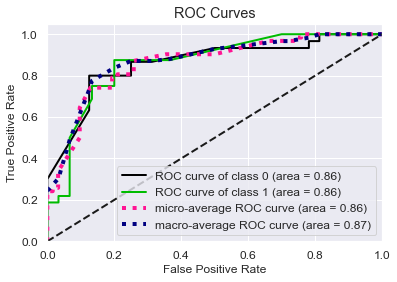

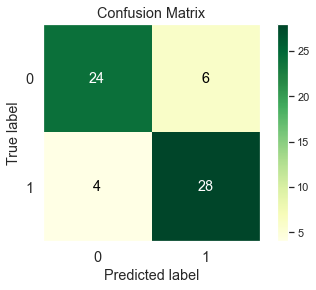

In [43]:
bal_rf = BalancedRandomForestClassifier(replacement = True, n_estimators = 740, min_samples_split = 4,  
                                        min_samples_leaf = 1, max_samples = 0.5, max_leaf_nodes = None,  
                                        max_features =  "sqrt" , max_depth = 6, criterion =  "entropy",  
                                        class_weight =  "balanced_subsample", ccp_alpha = 0.0005,  
                                        bootstrap = True)

evaluate_model(bal_rf, X_train_pars_df.values, y_train_df.target.values, 
               X_test_pars_df.values, y_test_df.target.values, cv=skf)

As seen above, at first, the accuracy on the test set was 79%, with a probability threshold of 50%. But, the ideal threshold which helps to maximise the F1 score was down to approxialy 30%. Hence, applying this new threshold, probability higher than 30% will be of class 1 and probability below 30% will be class zero. 




This helped significantly improve the overal model accuracy, from 79% accuracy to approximatly 84% model accuracy.